In [3]:
# This code is to take multiple on-chain data and test the unidirectional Garenger causality. For further information please refer to https://phdinds-aim.github.io/time_series_handbook/Preface/Preface.html
import json
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

In [4]:
# insert your API key, Start Date & End Date
current_date = datetime.now()
delta_date = 365
start_date = int(datetime.timestamp(current_date-timedelta(days = delta_date)))
end_date = int(datetime.timestamp(current_date))
API_KEY = '2B1pxzrRCwECISMvVhDJ5c3jtPi'

#print(start_date,end_date)

# make API request for X = STH-SOPR & Y = Price
res_x = requests.get('https://api.glassnode.com/v1/metrics/indicators/sopr_less_155',
    params={'a': 'BTC', 's': start_date, 'u': end_date, 'api_key': API_KEY})
res_y = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_close',
    params={'a': 'BTC', 's': start_date, 'u': end_date, 'api_key': API_KEY})

# convert to pandas dataframe
df_x = pd.read_json(res_x.text, convert_dates=['t'])
df_y = pd.read_json(res_y.text, convert_dates=['t'])

# build and print the first 5 rows of df
df = pd.concat([df_y['v'], df_x['v']], axis=1)
df.columns =['Price', 'STH-SOPR']
print(df.head(5))

          Price  STH-SOPR
0  16915.710105  0.998157
1  17137.597161  1.000897
2  16974.709590  0.998625
3  17085.275988  0.999037
4  16850.772516  0.991092


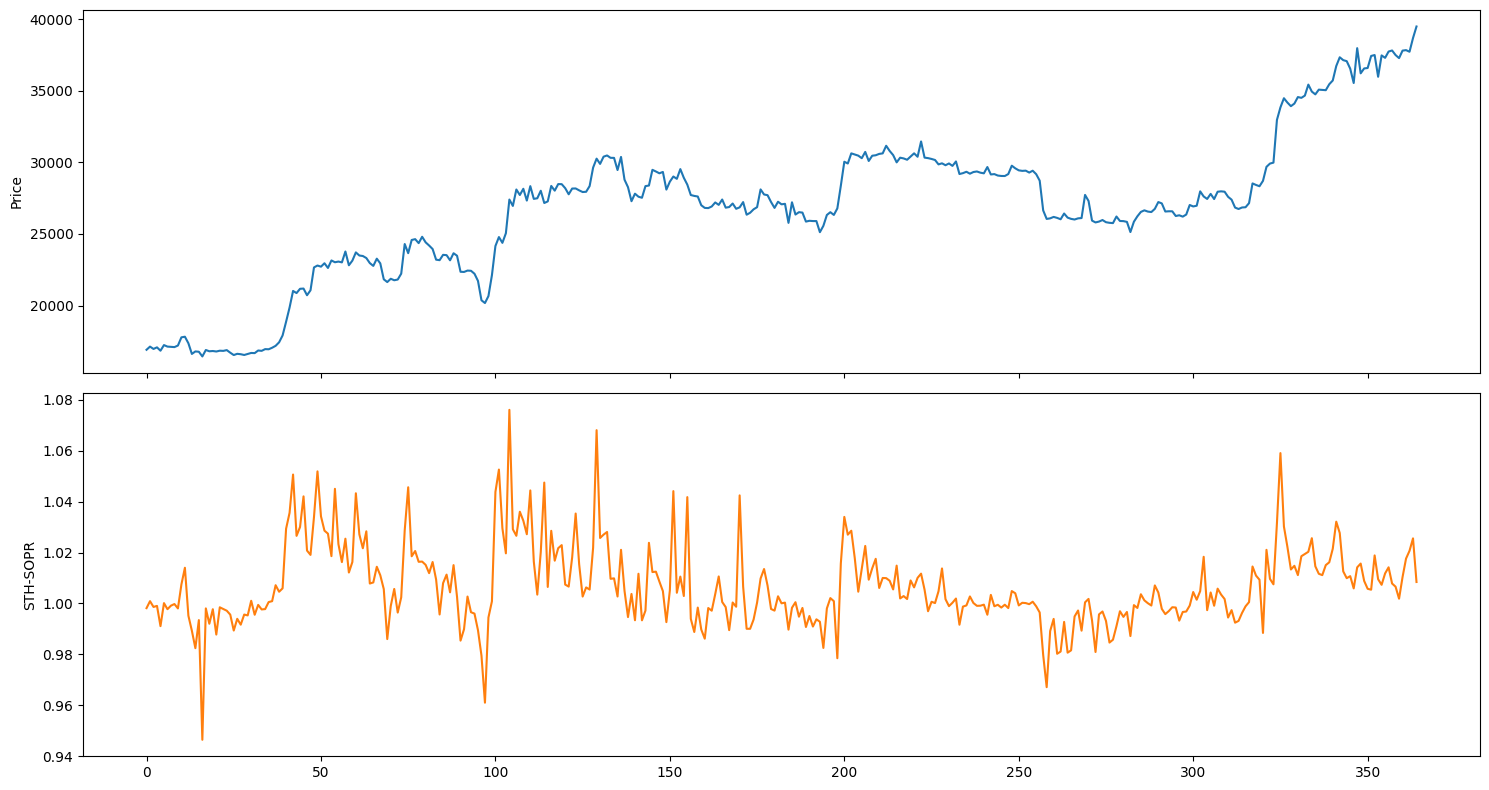

In [5]:
fig,ax = plt.subplots(df.shape[1], figsize=(15,8), sharex=True)
df.plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(df.columns[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

In [6]:
#lag plots to quickly check for stationarity
def lag_plots(data_df):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    lag_plot(data_df[data_df.columns[0]], ax=ax1)
    ax1.set_title(data_df.columns[0]);

    lag_plot(data_df[data_df.columns[1]], ax=ax2)
    ax2.set_title(data_df.columns[1]);

    ax1.set_ylabel('$y_{t+1}$');
    ax1.set_xlabel('$y_t$');
    ax2.set_ylabel('$y_{t+1}$');
    ax2.set_xlabel('$y_t$');

    plt.tight_layout()

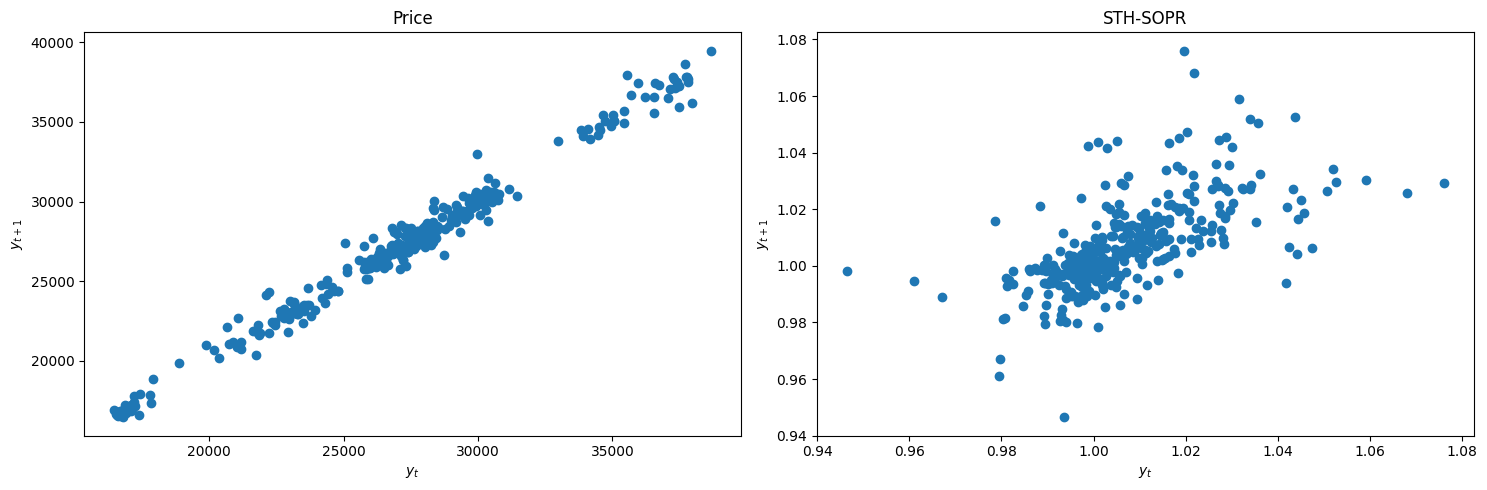

In [7]:
lag_plots(df)

In [8]:
#Use KPSS and ADF teststo conclusively check for stationarity
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data_df.columns: 
        kpss_res = kpss(data_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [9]:
kpss_test(df)

,Price,STH-SOPR
Test statistic,0.2967,0.1811
p-value,0.0100,0.0231
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


In [10]:
def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data_df.columns: 
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

In [11]:
adf_test(df)

,Price,STH-SOPR
Test statistic,-0.5660,-3.8492
p-value,0.8785,0.0024
Critical value - 1%,-3.4484,-3.4487
Critical value - 5%,-2.8695,-2.8696
Critical value - 10%,-2.5710,-2.5711


In [12]:
df['Price'] = df['Price']- df['Price'].shift(1)
df = df.dropna()
print(df_diff.head())

NameError: name 'df_diff' is not defined

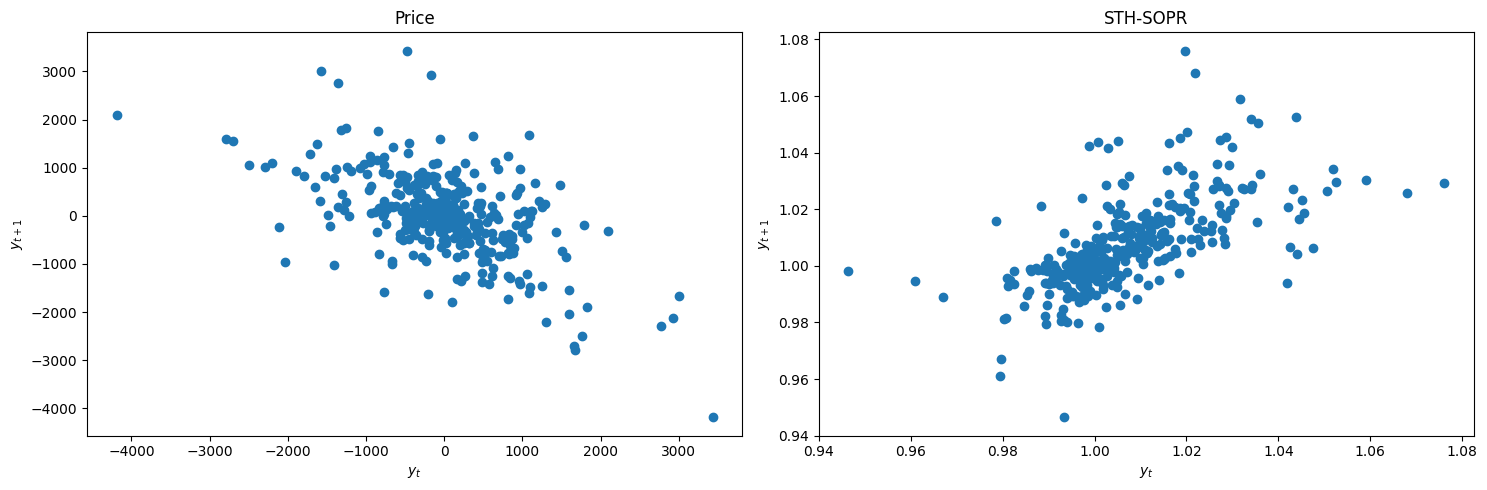

In [ ]:
lag_plots(df)

In [ ]:
kpss_test(df)
adf_test(df)

,Price,STH-SOPR
Test statistic,-8.1452,-3.8431
p-value,0.0000,0.0025
Critical value - 1%,-3.4494,-3.4488
Critical value - 5%,-2.8699,-2.8697
Critical value - 10%,-2.5712,-2.5711


In [ ]:
#Split the data into train and test sets for the VAR model.
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

In [ ]:
train_df, test_df = splitter(df)

In [ ]:
# Select the VAR order 𝑝 by computing the different multivariate information criteria (AIC, BIC, HQIC), and FPE.
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     17
BIC      3
HQIC     6
FPE     17
dtype: int64


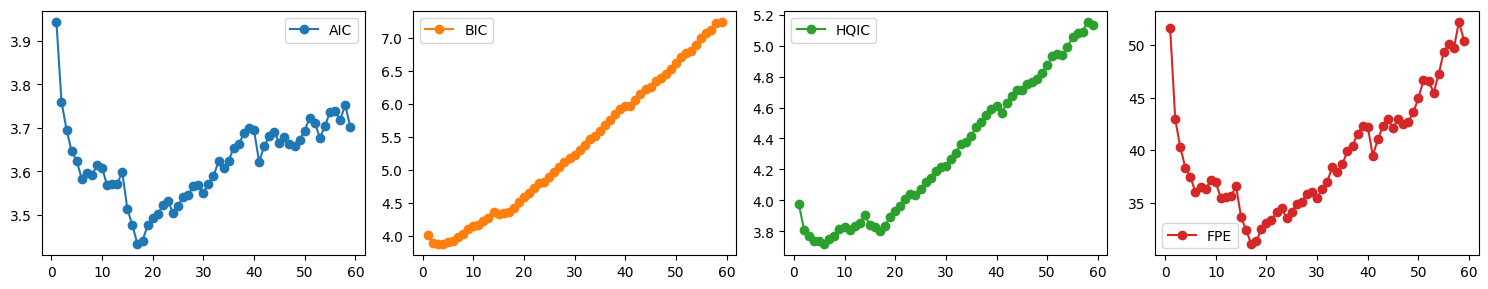

In [ ]:
select_p(train_df)

In [ ]:
p = 3
model = VAR(train_df)
var_model = model.fit(p)

In [ ]:
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
granger_causation_matrix(train_df, train_df.columns, p)  

,Price_x,STH-SOPR_x
Price_y,1.0,0.0
STH-SOPR_y,0.0,1.0
